# MS016 Preprocess
Created: 01/25/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS016'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/raw/MS016_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2351039  =      0.000 ...  2295.937 secs...


In [7]:
mne_data

<RawEDF | MS016_SWB.edf, 276 x 2351040 (2295.9 s), ~4.83 GB, data loaded>

In [8]:
# mne_data.ch_names

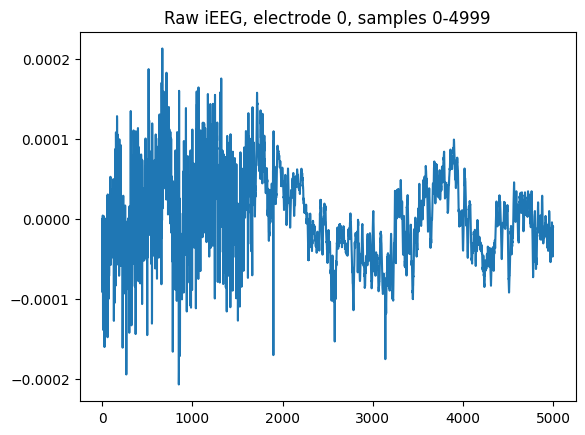

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   41.4s finished


<RawEDF | MS016_SWB.edf, 276 x 1147969 (2295.9 s), ~2.36 GB, data loaded>

### Photodiode
- examine photodiode 

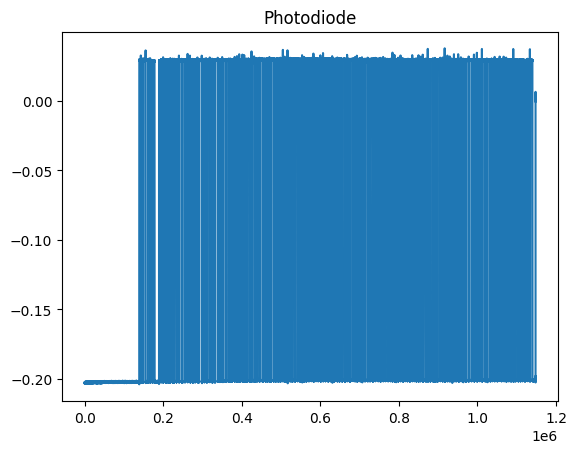

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [11]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/photodiode.fif
[done]


In [12]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

### Notch filter line noise

In [13]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    9.8s finished


<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

### Anatomical Localization

In [14]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [15]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCas1,A32sg_L,-4.195963,38.755833,1.548926,-4.923962,30.522125,-7.317985,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCas2,A24rv_L,-6.593655,39.555832,5.546539,-7.498945,32.166524,-2.505895,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,WM,NaN
2,LaCas3,Unknown,-8.991346,40.755832,9.544152,-10.170427,34.069446,2.265049,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LaCas4,Unknown,-11.389038,41.955831,13.941527,-12.808619,36.020665,7.462891,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
4,LaCas5,Unknown,-13.786730,43.155830,17.939140,-15.421547,37.883783,12.121384,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,llem14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
150,llem15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
151,llem16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
152,llem17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN


In [16]:
list(elec_locs.label)

['LaCas1',
 'LaCas2',
 'LaCas3',
 'LaCas4',
 'LaCas5',
 'LaCas6',
 'LaCas7',
 'LaCas8',
 'LaCas9',
 'LaCas10',
 'LaCas11',
 'LaCas12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LaImM1',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LILS1_1',
 'LILS1_2',
 'LILS1_3',
 'LILS1_4',
 'LILS1_5',
 'LILS1_6',
 'LILS1_7',
 'LILS1_8',
 'LILS2_1',
 'LILS2_2',
 'LILS2_3',
 'LILS2_4',
 'LILS2_5',
 'LILS2_6',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LMLS3_1',
 'LMLS3_2',
 'LMLS3_3',
 'LMLS3_4',
 'LMLS3_5',
 'LMLS3_6',
 'LMLS3_7',
 'LMLS3_8',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOl

In [17]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'lils21', 'lils22', 'lils23', 'lils24', 'lils25', 'lils26', 'lmls31', 'lmls32', 'lmls33', 'lmls34', 'lmls35', 'lmls36', 'lmls37', 'lmls38', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lils11', 'lils12', 'lils13', 'lils14', 'lils15', 'lils16', 'lils17', 'lils18', 'laims1', 'laims2', 'laims3', 'laims4', 'laims5', 'laims6', 'laims7', 'laims8', 'laims9', 'laims10', 'laims11', 'laims12', 'laims13', 'laims14', 'laims15', 'laims16', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c139', 'c140', 'c141', 'c142', 'c143', 'c144', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'chest1', 'chest2', 'abs1', 'abs2', 'c190', 'c191', 'c192', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', '

In [18]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [19]:
unmatched_seeg #make sure there are no unmatched names


[]

In [20]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [21]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'lagit1': 'lagit1',
 'lagit2': 'lagit2',
 'lagit3': 'lagit3',
 'lagit4': 'lagit4',
 'lagit5': 'lagit5',
 'lagit6': 'lagit6',
 'lagit7': 'lagit7',
 'lagit8': 'lagit8',
 'lagit9': 'lagit9',
 'lagit10': 'lagit10',
 'lagit11': 'lagit11',
 'lagit12': 'lagit12',
 'lhpit1': 'lhpit1',
 'lhpit2': 'lhpit2',
 'lhpit3': 'lhpit3',
 'lhpit4': 'lhpit4',
 'lhpit5': 'lhpit5',
 'lhpit6': 'lhpit6',
 'lhpit7': 'lhpit7',
 'lhpit8': 'lhpit8',
 'lhpit9': 'lhpit9',
 'lhpit10': 'lhpit10',
 'lils21': 'lils2_1',
 'lils22': 'lils2_2',
 'lils23': 'lils2_3',
 'lils24': 'lils2

In [22]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [23]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 121 left sEEG and 31 right sEEG electrodes
We have a total of 152 sEEG electrodes


In [24]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS016_SWB.edf, 152 x 1147969 (2295.9 s), ~1.30 GB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS016_SWB.edf, 152 x 1147969 (2295.9 s), ~1.30 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [27]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [28]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [29]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laimm': 16,
 'lham': 8,
 'lhpit': 10,
 'lils_': 14,
 'llem': 8,
 'lles': 8,
 'llesma': 6,
 'lmcms': 10,
 'lmls_': 8,
 'lmolf': 9,
 'racas': 12,
 'ragit': 9,
 'rhpit': 10,
 'ulmolf': 1,
 'uragit': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [30]:
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [30]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas12',
 'lacas7',
 'laimm15',
 'lham18',
 'lils1_7',
 'llem18',
 'lmcms3',
 'lmcms5',
 'lmcms6',
 'lmls3_3',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'ragit1',
 'ragit6']

<IPython.core.display.Javascript object>


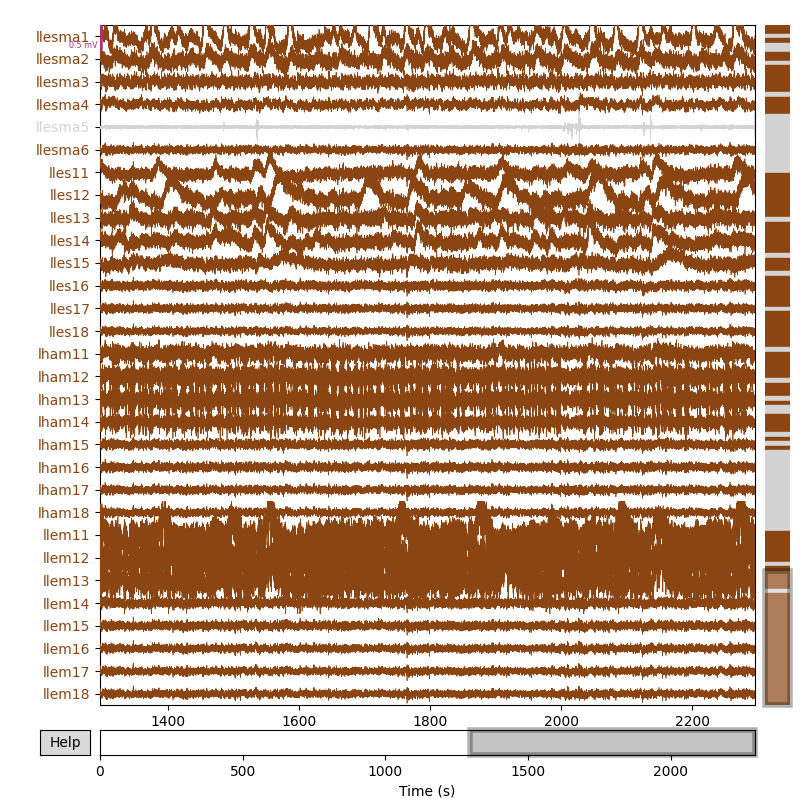

In [36]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/50)


In [27]:
mne_data.info['bads'] = ['lacas7',
 'lacas12',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'lmls3_3',
 'lmls3_7',
 'lils2_1',
 'ragit8',
 'rhpit6',
 'lils1_7',
 'rhpit10',
 'racas2',
 'racas3',
 'racas10',
 'racas8',
 'racas12',
 'llesma5',
 'lmcms1',
 'lmcms9',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'laimm15',
 'laimm16',
 'lagit1',
 'lagit2',
 'lagit3',
 'lagit4',
 'lagit5',
 'lagit6',
 'lagit8',
 'lagit9',
 'lagit10',
 'lagit11',
 'lagit12',
 'lagit7']

In [34]:
# mne_data.info['bads'] = ['lacas7',
#  'lacas12',
#  'lmolf3',
#  'lmolf5',
#  'lmolf6',
#  'lmolf9',
#  'lmls3_3',
#  'lmls3_7',
#  'lils2_1',
#  'ragit8',
#  'rhpit6',
#  'lils1_7',
#  'rhpit10',
#  'racas2',
#  'racas3',
#  'racas10',
#  'racas8',
#  'racas12',
#  'llesma5',
#  'lmcms1',
#  'ragit1',
#  'llem11',
#  'lmcms9']
# old 02/11/2024

In [28]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 49 items (lacas7, lacas12, lmolf3, lmolf5, lmolf6, lmolf9, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 152 sEEG
 custom_ref_applied: False
 dig: 152 items (152 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 12:14:17 UTC
 nchan: 152
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [29]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [30]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=40, n_times=1147969
    Range : 0 ... 1147968 =      0.000 ...  2295.936 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas8-lacas9, lacas9-lacas10, lhpit1-lhpit2, lhpit2-lhpit3, lhpit6-lhpit7, lhpit7-lhpit8, lhpit8-lhpit9, lhpit9-lhpit10, lils1_1-lils2_2, lils2_2-lils1_2, lils1_2-lils2_3, lils2_3-lils1_3, lils1_3-lils2_4, lils2_4-lils1_4, lils1_4-lils2_5, lils2_5-lils1_5, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms7-lmcms8, lmls3_1-lmls3_2, lmls3_2-lmls3_4, lmls3_4-lmls3_5, lmolf1-lmolf2, lmolf2-lmolf4, lmolf4-lmolf7, lmolf7-lmolf8, racas1-racas4, racas7-racas9, racas9-racas11, ragit1-ragit2, ragit2-ragit3, ragit7-ragit9, rhpit1-rhpit2, rhpit2-rhpit3, rhpit3-rhpit4, rhpit4-rhpit5, rhpit7-rhpit8, rhpit8-rhpit9


In [31]:
mne_data_bp_reref

<RawEDF | MS016_SWB.edf, 40 x 1147969 (2295.9 s), ~350.4 MB, data loaded>

In [32]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lhpit1-lhpit2',
 'lhpit2-lhpit3',
 'lhpit6-lhpit7',
 'lhpit7-lhpit8',
 'lhpit8-lhpit9',
 'lhpit9-lhpit10',
 'lils1_1-lils2_2',
 'lils2_2-lils1_2',
 'lils1_2-lils2_3',
 'lils2_3-lils1_3',
 'lils1_3-lils2_4',
 'lils2_4-lils1_4',
 'lils1_4-lils2_5',
 'lils2_5-lils1_5',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms7-lmcms8',
 'lmls3_1-lmls3_2',
 'lmls3_2-lmls3_4',
 'lmls3_4-lmls3_5',
 'lmolf1-lmolf2',
 'lmolf2-lmolf4',
 'lmolf4-lmolf7',
 'lmolf7-lmolf8',
 'racas1-racas4',
 'racas7-racas9',
 'racas9-racas11',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'ragit7-ragit9',
 'rhpit1-rhpit2',
 'rhpit2-rhpit3',
 'rhpit3-rhpit4',
 'rhpit4-rhpit5',
 'rhpit7-rhpit8',
 'rhpit8-rhpit9']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


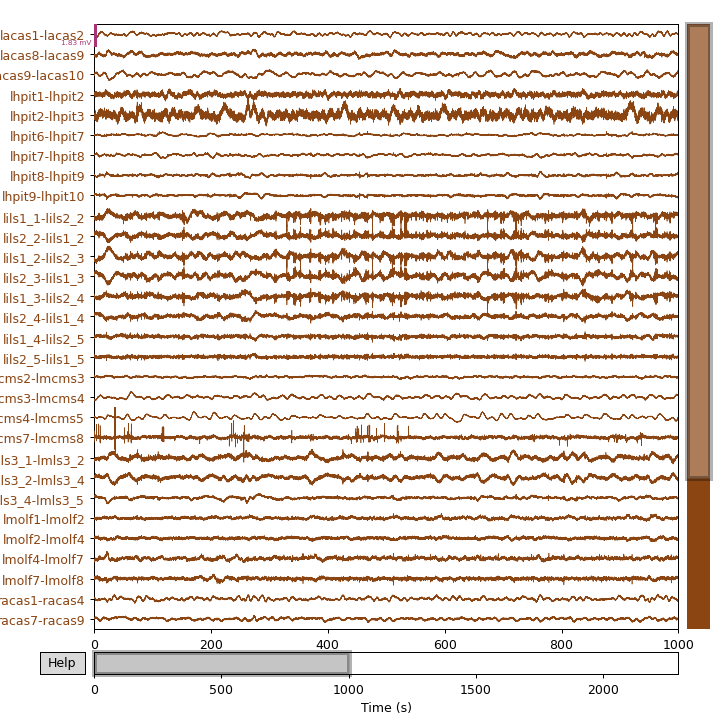

In [10]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=30, scalings=mne_data_bp_reref._data.max()/5)


Effective window size : 0.512 (s)


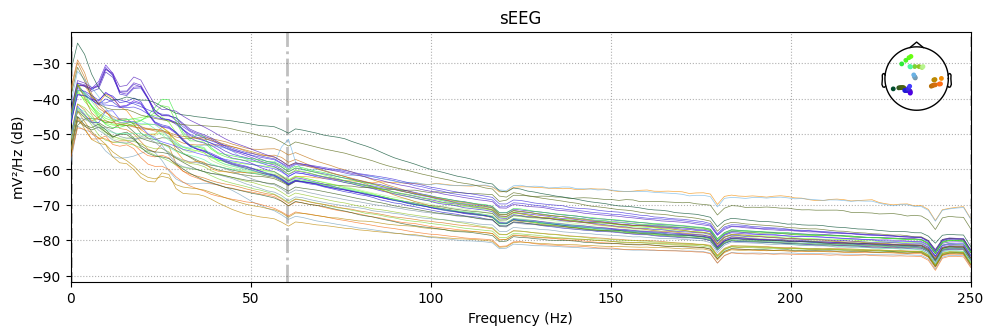

In [33]:
mne_data_bp_reref.compute_psd().plot()

In [34]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/bp_ref_ieeg.fif
[done]


## Save mne_data

In [35]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [36]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [37]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/photodiode.fif...
Isotrak not found
    Range : 0 ... 1147968 =      0.000 ...  2295.936 secs
Ready.
Reading 0 ... 1147968  =      0.000 ...  2295.936 secs...


In [38]:
photodiode_data

<Raw | photodiode.fif, 1 x 1147969 (2295.9 s), ~8.8 MB, data loaded>

In [39]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.5

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 156 pulses


In [40]:
print(slope, offset,smoothSize,windSize,height)

0.999987203028442 -43.731048916198006 11 15 0.5


In [41]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n




In [42]:
pulses = [(x*slope + offset) for x in beh_ts]
# moving_average
neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.5)
neural_ts.shape



(156,)

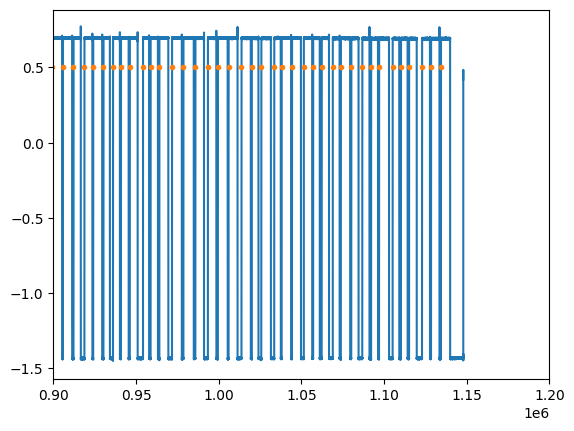

In [47]:

# plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
# plt.show()

plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([900000,1200000])
plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [48]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [49]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [50]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [51]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/bp_ref_ieeg.fif...
    Range : 0 ... 1147968 =      0.000 ...  2295.936 secs
Ready.
Reading 0 ... 1147968  =      0.000 ...  2295.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.0s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 40 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/bp_ref_ieeg.fif...
    Range : 0 ... 1147968 =      0.000 ...  2295.936 secs
Ready.
Reading 0 ... 1147968  =      0.000 ...  2295.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 40 columns


In [52]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~68.8 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~160.4 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [53]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [54]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 62 columns
Replacing existing metadata with 62 columns


In [55]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas8-lacas9,lacas9-lacas10,lhpit1-lhpit2,lhpit2-lhpit3,lhpit6-lhpit7,lhpit7-lhpit8,lhpit8-lhpit9,lhpit9-lhpit10,lils1_1-lils2_2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.92,-1.92,-1.92,-1.92,0.00,0.00,2.52,2.52,0.000,0.000
1,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,NaN,NaN,...,0.91,0.41,0.00,0.00,0.91,0.41,-0.50,0.00,0.455,0.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.36,-0.30,-0.36,-0.30,0.00,0.00,0.06,0.00,0.000,-0.180
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.95,-0.30,-0.95,-0.30,0.00,0.00,0.95,0.30,0.000,-0.475
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30,0.30,0.00,0.00,0.30,0.30,0.00,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.12,-0.72,-1.12,-0.72,0.00,0.00,0.00,-0.40,0.000,-0.560
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,0.40,0.00,0.00,0.89,0.40,-0.89,-0.40,0.445,0.000
147,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.40,-0.90,-1.40,-0.90,0.00,0.00,0.00,-0.50,0.000,-0.700
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.000,0.000


### Save raw epoched data 

In [56]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [57]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [58]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [59]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [60]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [61]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 40, ~688.1 MB>}

In [62]:
power_epochs = {}

In [63]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 62 columns


In [64]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 40, ~3.35 GB>

In [65]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [66]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [32]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [ ]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


-43.731048916198006
